In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-29 10:08:21.578741: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 10:08:22.811144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-29 10:08:22.811238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-29 10:08:22.811247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging'
background = 50
photons_per_pixel = 400
patch_size = 78
gaussian_noise_sigma = 15
sample = '2_plane_lung_uniform_patches_gaussian_noise_sigma_15'

single_lens_data = np.load(os.path.join(data_path, '2_plane_lung_single_lens.npy'))
double_lens_data = np.load(os.path.join(data_path, '2_plane_lung_double_lens.npy'))
many_lens_data = np.load(os.path.join(data_path, '2_plane_lung_many_lens.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())

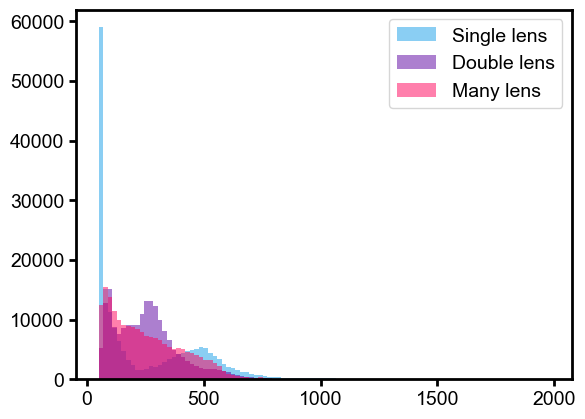

In [ ]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

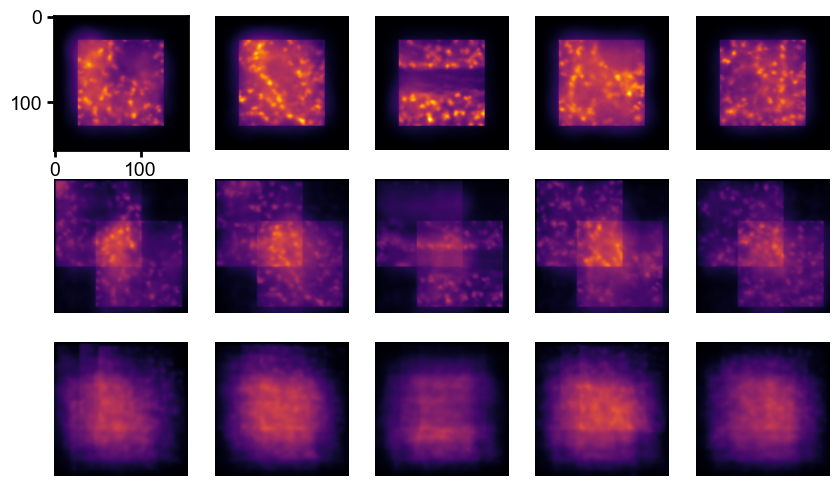

In [3]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

# Generate and train

100%|██████████| 10/10 [00:00<00:00, 123.81it/s]


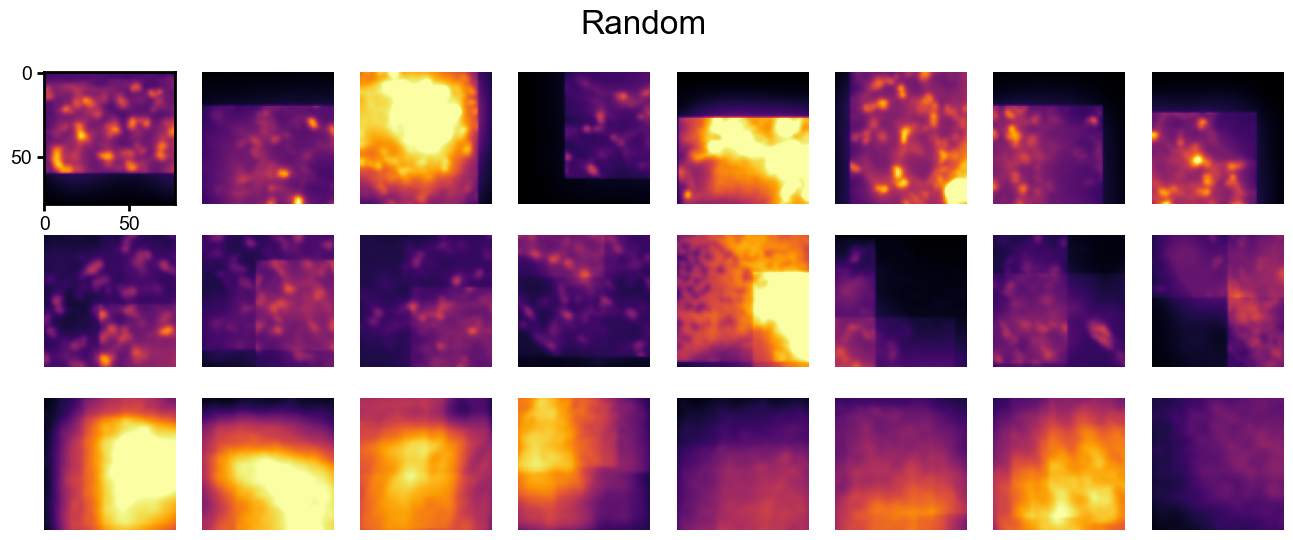

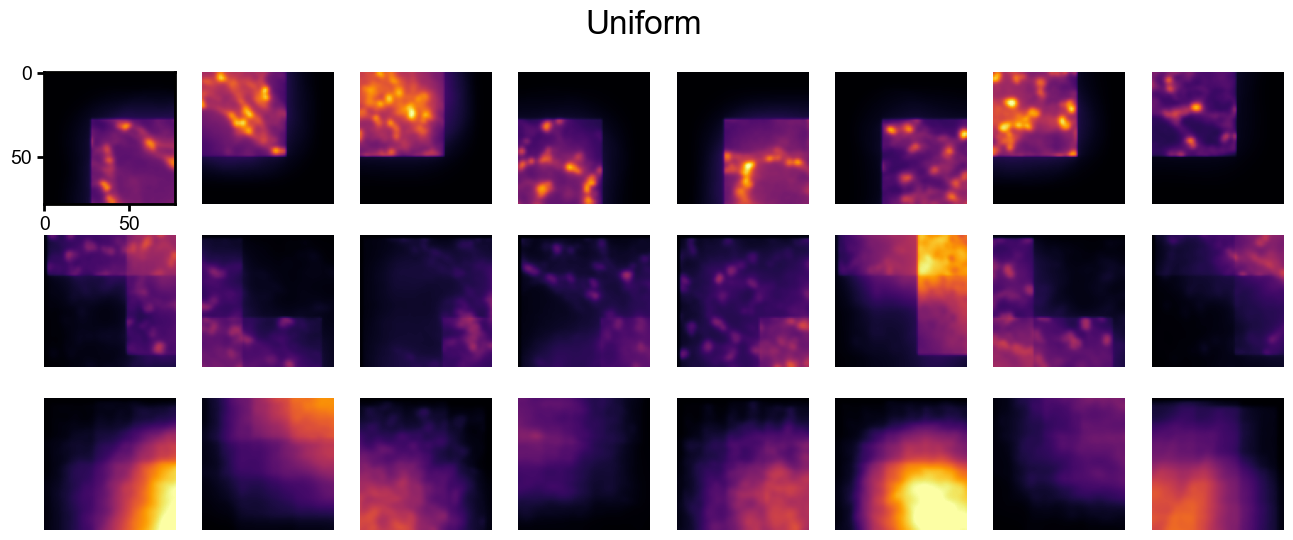

In [3]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]


vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


for uniform in [False, True]:

    if uniform:
        single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
    else:
        single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        

    fig, axs = plt.subplots(3, 8, figsize=(16, 6))

    for i in range(8):
        axs[0, i].imshow(single_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[1, i].imshow(double_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[2, i].imshow(many_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        if i != 0:
            axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[2, i].axis('off')
    fig.suptitle('Uniform' if uniform else 'Random')

In [4]:

for i in range(10):

    # single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches, gaussian_sigma=gaussian_noise_sigma)
    double_lens_noisy_patches = add_noise(double_lens_patches, gaussian_sigma=gaussian_noise_sigma)
    many_lens_noisy_patches = add_noise(many_lens_patches, gaussian_sigma=gaussian_noise_sigma)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, gaussian_noise_sigma=gaussian_noise_sigma,
                                                      entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, 
                                                      gaussian_noise_sigma=gaussian_noise_sigma,
                                                      entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, gaussian_noise_sigma=gaussian_noise_sigma,
                                                    entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, 
                                                            gaussian_noise_sigma=gaussian_noise_sigma,
                                                          verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,
                                                          gaussian_noise_sigma=gaussian_noise_sigma,
                                                            verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches,
                                                        gaussian_noise_sigma=gaussian_noise_sigma,
                                                         verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')

    save_data(single_lens_mi_gaussian, 'gaussian', 'single_lens')
    save_data(double_lens_mi_gaussian, 'gaussian', 'double_lens')
    save_data(many_lens_mi_gaussian, 'gaussian', 'many_lens')

Initial validation NLL: 473.36


Epoch 1: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Epoch 1: validation NLL: 6.38


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 2: validation NLL: 5.80


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 3: validation NLL: 5.58


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 4: validation NLL: 5.09


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 5: validation NLL: 5.10


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 6: validation NLL: 5.04


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 7: validation NLL: 4.76


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 8: validation NLL: 5.35


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 9: validation NLL: 4.80


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 10: validation NLL: 4.80


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 12: validation NLL: 4.75


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 13: validation NLL: 4.98


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 14: validation NLL: 4.87


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 15: validation NLL: 4.85


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 16: validation NLL: 4.55


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 17: validation NLL: 4.59


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 18: validation NLL: 4.69


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 20: validation NLL: 4.49


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 21: validation NLL: 4.74


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 22: validation NLL: 4.44


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 24: validation NLL: 4.44


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 25: validation NLL: 4.90


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 26: validation NLL: 4.48


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 27: validation NLL: 4.64


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 28: validation NLL: 4.54


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 29: validation NLL: 4.57


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 30: validation NLL: 4.39


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 31: validation NLL: 4.38


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 32: validation NLL: 4.39


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 33: validation NLL: 4.45


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 34: validation NLL: 4.60


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 35: validation NLL: 4.44


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 36: validation NLL: 4.41


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 37: validation NLL: 4.45


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 38: validation NLL: 4.48


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 39: validation NLL: 4.41


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 40: validation NLL: 4.48


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 41: validation NLL: 4.79


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 42: validation NLL: 4.65


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 43: validation NLL: 4.66


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 44: validation NLL: 4.52


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 45: validation NLL: 4.44


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 46: validation NLL: 4.61


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 47: validation NLL: 4.38


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 48: validation NLL: 4.36


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 49: validation NLL: 4.41


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 50: validation NLL: 4.42


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 51: validation NLL: 4.37


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 52: validation NLL: 4.35


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 53: validation NLL: 4.46


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 54: validation NLL: 4.42


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 55: validation NLL: 4.40


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 56: validation NLL: 5.12


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 57: validation NLL: 4.46


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 58: validation NLL: 4.70


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 59: validation NLL: 4.46


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 60: validation NLL: 4.36


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 61: validation NLL: 4.35


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 62: validation NLL: 4.38


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 63: validation NLL: 4.36


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 64: validation NLL: 4.53


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 65: validation NLL: 6.96


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 66: validation NLL: 6.81


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 67: validation NLL: 7.20


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 68: validation NLL: 7.19


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 69: validation NLL: 7.19


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 70: validation NLL: 7.19


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 71: validation NLL: 7.19


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 72: validation NLL: 7.19


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 73: validation NLL: 7.19


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 74: validation NLL: 7.19


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 75: validation NLL: 7.19


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 76: validation NLL: 7.19


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 77: validation NLL: 7.19


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 78: validation NLL: 7.19


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 79: validation NLL: 7.19


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 80: validation NLL: 7.19


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 81: validation NLL: 7.19


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 82: validation NLL: 7.19


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 83: validation NLL: 7.19


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 84: validation NLL: 7.19


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 85: validation NLL: 7.19


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 86: validation NLL: 7.19


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 87: validation NLL: 7.19


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 88: validation NLL: 7.19


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 89: validation NLL: 7.19


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 90: validation NLL: 7.19


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 91: validation NLL: 7.19


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 92: validation NLL: 7.19
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.349 differential entropy/pixel
Estimated I(Y;X) = 0.320 bits/pixel
Initial validation NLL: 338.99


Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


Epoch 1: validation NLL: 6.35


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 2: validation NLL: 6.21


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 3: validation NLL: 5.89


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 4: validation NLL: 5.37


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 5: validation NLL: 4.87


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 6: validation NLL: 5.67


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 10: validation NLL: 4.64


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 13: validation NLL: 4.47


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 14: validation NLL: 4.50


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 15: validation NLL: 4.45


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 17: validation NLL: 4.41


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 18: validation NLL: 4.39


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 19: validation NLL: 4.39


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 20: validation NLL: 4.38


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 21: validation NLL: 4.38


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 22: validation NLL: 4.44


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 23: validation NLL: 4.38


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 24: validation NLL: 4.44


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 25: validation NLL: 4.40


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 27: validation NLL: 4.41


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 28: validation NLL: 4.37


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 31: validation NLL: 4.59


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 32: validation NLL: 4.68


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 33: validation NLL: 4.39


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 34: validation NLL: 4.39


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 35: validation NLL: 4.35


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 36: validation NLL: 4.51


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 37: validation NLL: 4.37


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 38: validation NLL: 4.54


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 39: validation NLL: 4.37


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 40: validation NLL: 4.35


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 41: validation NLL: 4.37


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 42: validation NLL: 4.36


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 43: validation NLL: 4.38


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 44: validation NLL: 4.36


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 45: validation NLL: 4.37


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 46: validation NLL: 4.37


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 47: validation NLL: 5.17


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 48: validation NLL: 5.41


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 49: validation NLL: 5.17


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 50: validation NLL: 4.55


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 51: validation NLL: 5.15


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 52: validation NLL: 4.46


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 53: validation NLL: 4.43


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 54: validation NLL: 4.68


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 55: validation NLL: 4.67


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 56: validation NLL: 4.67


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 57: validation NLL: 4.43


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 58: validation NLL: 4.39


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 59: validation NLL: 4.39


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 60: validation NLL: 4.45


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 62: validation NLL: 4.53


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 63: validation NLL: 4.59


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 64: validation NLL: 4.39


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 65: validation NLL: 4.39


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 66: validation NLL: 4.38


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 67: validation NLL: 4.37


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 68: validation NLL: 4.37


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 69: validation NLL: 4.39


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 70: validation NLL: 4.39


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 71: validation NLL: 4.37


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 72: validation NLL: 4.38


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 73: validation NLL: 4.37


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 74: validation NLL: 4.36


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 75: validation NLL: 4.37


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 76: validation NLL: 4.38


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 77: validation NLL: 4.40


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 78: validation NLL: 4.40


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 79: validation NLL: 4.36


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 80: validation NLL: 4.41
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.355 differential entropy/pixel
Estimated I(Y;X) = 0.328 bits/pixel
Initial validation NLL: 408.93


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Epoch 1: validation NLL: 6.03


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 2: validation NLL: 5.76


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 3: validation NLL: 4.86


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 4: validation NLL: 4.60


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 5: validation NLL: 4.64


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 6: validation NLL: 4.59


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 7: validation NLL: 4.81


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 8: validation NLL: 4.79


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 10: validation NLL: 4.65


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 11: validation NLL: 4.63


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 12: validation NLL: 4.41


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 15: validation NLL: 4.87


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 16: validation NLL: 4.45


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 17: validation NLL: 4.43


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 18: validation NLL: 4.81


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 19: validation NLL: 4.75


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 20: validation NLL: 4.34


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 22: validation NLL: 4.38


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 23: validation NLL: 5.68


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 24: validation NLL: 4.46


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 26: validation NLL: 4.36


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 27: validation NLL: 4.46


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 28: validation NLL: 4.37


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 29: validation NLL: 4.66


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 30: validation NLL: 4.37


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 31: validation NLL: 4.51


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 32: validation NLL: 6.26


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 33: validation NLL: 4.41


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 34: validation NLL: 4.34


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 35: validation NLL: 4.59


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 36: validation NLL: 4.40


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 37: validation NLL: 4.30


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 38: validation NLL: 5.98


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 39: validation NLL: 5.39


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 40: validation NLL: 5.64


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 41: validation NLL: 5.06


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 42: validation NLL: 4.62


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 43: validation NLL: 4.52


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 44: validation NLL: 4.42


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 45: validation NLL: 4.44


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 46: validation NLL: 4.61


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 47: validation NLL: 4.85


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 48: validation NLL: 4.47


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 49: validation NLL: 4.35


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 51: validation NLL: 4.36


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 52: validation NLL: 4.36


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 53: validation NLL: 4.79


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 54: validation NLL: 4.33


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 55: validation NLL: 4.38


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 56: validation NLL: 4.37


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 57: validation NLL: 4.39


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 58: validation NLL: 4.40


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 59: validation NLL: 4.37


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 60: validation NLL: 4.34


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 61: validation NLL: 4.33


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 62: validation NLL: 4.36


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 63: validation NLL: 4.32


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 64: validation NLL: 4.32


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 65: validation NLL: 4.47


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 66: validation NLL: 4.31


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 67: validation NLL: 4.32


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 68: validation NLL: 4.36


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 69: validation NLL: 4.44


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 70: validation NLL: 5.80


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 71: validation NLL: 6.57


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 72: validation NLL: 6.10


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 73: validation NLL: 5.46


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 74: validation NLL: 5.42


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 75: validation NLL: 4.85


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 76: validation NLL: 6.02


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 77: validation NLL: 4.55
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.300 differential entropy/pixel
Estimated I(Y;X) = 0.250 bits/pixel


2024-01-29 11:24:18.124420: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-01-29 11:34:26.054401: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 12m7.93024557s

********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Initial validation NLL: 9702014.76


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]2024-01-29 11:54:03.032985: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 12m9.475008259s

********************************
[Compiling module jit__train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch 1: 100%|██████████| 1/1 [18:31<00:00, 1111.04s/it]


Epoch 1: validation NLL: 8528799.12


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 2: validation NLL: 7368435.99


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 3: validation NLL: 7014713.71


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 4: validation NLL: 6646508.09


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 5: validation NLL: 6333050.21


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 6: validation NLL: 6077013.19


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 7: validation NLL: 5497074.06


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 8: validation NLL: 5312614.95


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 9: validation NLL: 5159266.10


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 10: validation NLL: 5038949.27


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 11: validation NLL: 4927496.00


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 12: validation NLL: 4818047.78


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 13: validation NLL: 4703936.37


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 14: validation NLL: 4578866.91


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 15: validation NLL: 4438026.15


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 16: validation NLL: 4278974.05


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 17: validation NLL: 4102952.88


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 18: validation NLL: 3915413.15


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 19: validation NLL: 3724408.35


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 20: validation NLL: 3538511.36


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 21: validation NLL: 3364344.12


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 22: validation NLL: 3205693.12


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 23: validation NLL: 3063912.56


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 24: validation NLL: 2938364.27


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 25: validation NLL: 2826998.72


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 26: validation NLL: 2727866.72


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 27: validation NLL: 2639492.91


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 28: validation NLL: 2560387.50


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 29: validation NLL: 2489110.35


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 30: validation NLL: 2424479.24


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 31: validation NLL: 2365419.56


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 32: validation NLL: 2311155.68


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 33: validation NLL: 2260764.13


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 34: validation NLL: 2213566.79


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 35: validation NLL: 2168844.37


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 36: validation NLL: 2125985.62


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 37: validation NLL: 2084268.58


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 38: validation NLL: 100020.73


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 39: validation NLL: 1948052.35


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 40: validation NLL: 96481.38


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 41: validation NLL: 94761.65


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 42: validation NLL: 93058.21


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 43: validation NLL: 91293.05


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 44: validation NLL: 89508.05


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 45: validation NLL: 87716.91


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 46: validation NLL: 85899.33


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 47: validation NLL: 84058.55


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 48: validation NLL: 82221.03


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 49: validation NLL: 80355.25


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 50: validation NLL: 78499.96


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 51: validation NLL: 76631.03


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 52: validation NLL: 74769.25


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 53: validation NLL: 72909.25


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 54: validation NLL: 71053.50


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 55: validation NLL: 69206.94


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 56: validation NLL: 67372.46


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 57: validation NLL: 65556.07


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 58: validation NLL: 63754.57


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 59: validation NLL: 14.76


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 60: validation NLL: 13.11


precomputing masks and variances: 100%|██████████| 78/78 [00:03<00:00, 25.83it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 31.45it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13.132 differential entropy/pixel
Estimated I(Y;X) = 12.991 bits/pixel
Initial validation NLL: 1542605.45


Epoch 1: 100%|██████████| 1/1 [06:42<00:00, 402.56s/it]


Epoch 1: validation NLL: 1433314.83


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 2: validation NLL: 1367097.91


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 3: validation NLL: 1329380.88


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 4: validation NLL: 1291702.12


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 5: validation NLL: 1249063.29


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 6: validation NLL: 1190447.42


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 7: validation NLL: 1108533.83


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 8: validation NLL: 1024327.13


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 9: validation NLL: 924002.94


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 10: validation NLL: 859975.89


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 11: validation NLL: 810747.29


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 12: validation NLL: 769574.07


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 13: validation NLL: 732427.36


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 14: validation NLL: 694915.82


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 15: validation NLL: 667702.19


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 16: validation NLL: 644246.00


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 17: validation NLL: 623578.76


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 18: validation NLL: 607067.15


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 19: validation NLL: 591958.81


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 20: validation NLL: 578664.26


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 21: validation NLL: 566844.16


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 22: validation NLL: 556233.61


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 23: validation NLL: 546394.65


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 24: validation NLL: 537526.93


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 25: validation NLL: 529302.07


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 26: validation NLL: 521517.05


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 27: validation NLL: 514060.75


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 28: validation NLL: 506865.00


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 29: validation NLL: 499784.91


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 30: validation NLL: 492752.01


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 31: validation NLL: 485706.44


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 32: validation NLL: 478583.48


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 33: validation NLL: 471357.35


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 34: validation NLL: 464010.57


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 35: validation NLL: 456529.32


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 36: validation NLL: 448902.80


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 37: validation NLL: 441176.65


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 38: validation NLL: 433353.20


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 39: validation NLL: 425484.53


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 40: validation NLL: 417596.16


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 41: validation NLL: 409765.34


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 42: validation NLL: 401989.76


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 43: validation NLL: 394325.96


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 44: validation NLL: 386804.27


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 45: validation NLL: 379455.44


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 46: validation NLL: 372301.63


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 47: validation NLL: 365362.88


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 48: validation NLL: 358634.70


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 49: validation NLL: 352154.70


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 50: validation NLL: 345898.01


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 51: validation NLL: 339880.87


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 52: validation NLL: 334094.27


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 53: validation NLL: 328543.17


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 54: validation NLL: 323208.42


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 55: validation NLL: 318089.23


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 56: validation NLL: 313184.88


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 57: validation NLL: 308474.16


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 58: validation NLL: 303951.27


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 59: validation NLL: 299607.18


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 60: validation NLL: 295446.31


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 37.85it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 37.45it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 310907.997 differential entropy/pixel
Estimated I(Y;X) = 448539.471 bits/pixel
Initial validation NLL: 3399263.29


Epoch 1: 100%|██████████| 1/1 [05:27<00:00, 327.62s/it]


Epoch 1: validation NLL: 3207396.35


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 2: validation NLL: 3053947.18


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 3: validation NLL: 2891518.82


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 4: validation NLL: 2696181.94


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 5: validation NLL: 2480395.52


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 6: validation NLL: 2259335.22


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 7: validation NLL: 2085353.35


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 8: validation NLL: 1944257.59


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 9: validation NLL: 1834380.51


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 10: validation NLL: 1749505.74


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 11: validation NLL: 1682317.08


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 12: validation NLL: 1627426.19


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 13: validation NLL: 1580541.10


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 14: validation NLL: 1538830.68


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 15: validation NLL: 1501497.59


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 16: validation NLL: 1466829.86


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 17: validation NLL: 1434050.19


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 18: validation NLL: 1403347.74


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 19: validation NLL: 1373143.61


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 20: validation NLL: 1343691.42


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 21: validation NLL: 1314857.29


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 22: validation NLL: 1286492.91


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 23: validation NLL: 1258554.15


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 24: validation NLL: 1230991.16


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 25: validation NLL: 1203828.86


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 26: validation NLL: 1177042.58


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 27: validation NLL: 1150735.55


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 28: validation NLL: 1124952.43


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 29: validation NLL: 1099700.17


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 30: validation NLL: 1075064.50


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 31: validation NLL: 1051122.62


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 32: validation NLL: 1027890.32


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 33: validation NLL: 1005378.79


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 34: validation NLL: 983602.99


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 35: validation NLL: 962579.53


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 36: validation NLL: 942302.79


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 37: validation NLL: 922730.43


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 38: validation NLL: 903862.48


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 39: validation NLL: 885681.50


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 40: validation NLL: 868170.91


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 41: validation NLL: 851300.69


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 42: validation NLL: 835020.89


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 43: validation NLL: 819343.36


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 44: validation NLL: 804243.27


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 45: validation NLL: 789674.48


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 46: validation NLL: 775647.27


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 47: validation NLL: 762116.08


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 48: validation NLL: 749061.20


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 49: validation NLL: 736478.19


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 50: validation NLL: 724352.26


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 51: validation NLL: 712653.11


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.58s/it]


Epoch 52: validation NLL: 701351.18


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 53: validation NLL: 690449.61


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 54: validation NLL: 679918.34


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 55: validation NLL: 669772.66


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 56: validation NLL: 659965.25


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 57: validation NLL: 650494.74


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 58: validation NLL: 641351.17


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 59: validation NLL: 632501.73


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 60: validation NLL: 623937.23


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 39.55it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 30.89it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 600959.861 differential entropy/pixel
Estimated I(Y;X) = 866995.857 bits/pixel
Initial validation NLL: 500.98


Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Epoch 1: validation NLL: 6.29


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 2: validation NLL: 5.96


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 3: validation NLL: 5.56


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 4: validation NLL: 5.37


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 5: validation NLL: 6.10


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 6: validation NLL: 5.15


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 7: validation NLL: 5.08


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 8: validation NLL: 4.77


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 9: validation NLL: 10.05


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 10: validation NLL: 4.92


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 11: validation NLL: 4.63


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 12: validation NLL: 4.66


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 14: validation NLL: 4.55


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 15: validation NLL: 5.64


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 16: validation NLL: 4.72


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 18: validation NLL: 4.52


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 20: validation NLL: 4.54


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 21: validation NLL: 4.68


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 23: validation NLL: 4.47


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 24: validation NLL: 4.60


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 25: validation NLL: 4.39


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 26: validation NLL: 4.43


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 27: validation NLL: 4.38


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 28: validation NLL: 4.60


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 30: validation NLL: 4.41


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 31: validation NLL: 4.86


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 32: validation NLL: 4.41


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 34: validation NLL: 4.66


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 35: validation NLL: 4.37


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 37: validation NLL: 4.39


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 38: validation NLL: 4.38


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 40: validation NLL: 4.34


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 42: validation NLL: 4.55


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 43: validation NLL: 4.54


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 44: validation NLL: 4.40


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 45: validation NLL: 4.47


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 46: validation NLL: 4.38


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 47: validation NLL: 4.44


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 48: validation NLL: 4.35


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 49: validation NLL: 4.39


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 50: validation NLL: 4.49


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 51: validation NLL: 4.34


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 52: validation NLL: 4.41


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 53: validation NLL: 4.35


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 54: validation NLL: 4.34


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 55: validation NLL: 4.35


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 56: validation NLL: 4.41


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 57: validation NLL: 4.33


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 58: validation NLL: 4.34


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 59: validation NLL: 4.49


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 60: validation NLL: 4.49


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 61: validation NLL: 4.36


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 62: validation NLL: 4.38


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 63: validation NLL: 4.45


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 64: validation NLL: 4.59


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 65: validation NLL: 4.37


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 66: validation NLL: 4.43


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 67: validation NLL: 4.38


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 68: validation NLL: 4.33


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 69: validation NLL: 4.35


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 70: validation NLL: 4.33


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 71: validation NLL: 4.49


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 72: validation NLL: 4.45


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 73: validation NLL: 4.46


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 74: validation NLL: 4.33


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 75: validation NLL: 4.33


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 76: validation NLL: 4.36


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 77: validation NLL: 4.34


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 79: validation NLL: 4.33


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 80: validation NLL: 4.34


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 81: validation NLL: 4.32


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 82: validation NLL: 4.33


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 83: validation NLL: 4.34


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 84: validation NLL: 4.75


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 85: validation NLL: 7.31


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 86: validation NLL: 7.17


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 87: validation NLL: 7.17


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 88: validation NLL: 7.16


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 89: validation NLL: 7.16


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 90: validation NLL: 7.16


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 91: validation NLL: 7.16


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 92: validation NLL: 7.16


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 93: validation NLL: 7.16


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 94: validation NLL: 7.16


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 95: validation NLL: 7.16


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 96: validation NLL: 7.16


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 97: validation NLL: 7.16


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 98: validation NLL: 7.16


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 99: validation NLL: 7.16


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 100: validation NLL: 7.16


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 101: validation NLL: 7.16


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 102: validation NLL: 7.16


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 103: validation NLL: 7.16


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 104: validation NLL: 7.16


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 105: validation NLL: 7.16


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 106: validation NLL: 7.16


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 107: validation NLL: 7.16


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 108: validation NLL: 7.16


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 109: validation NLL: 7.16


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 110: validation NLL: 7.16


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 111: validation NLL: 7.16


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 112: validation NLL: 7.16


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 113: validation NLL: 7.16


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 114: validation NLL: 7.16


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 115: validation NLL: 7.16


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 116: validation NLL: 7.16


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 117: validation NLL: 7.16


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 118: validation NLL: 7.16


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 119: validation NLL: 7.16


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 120: validation NLL: 7.16


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 121: validation NLL: 7.16
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.321 differential entropy/pixel
Estimated I(Y;X) = 0.280 bits/pixel
Initial validation NLL: 417.19


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Epoch 1: validation NLL: 5.72


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 2: validation NLL: 5.79


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 3: validation NLL: 4.90


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 4: validation NLL: 4.94


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 5: validation NLL: 4.70


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 6: validation NLL: 4.69


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 8: validation NLL: 4.46


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 9: validation NLL: 4.72


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 10: validation NLL: 4.69


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 11: validation NLL: 4.50


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 12: validation NLL: 4.75


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 13: validation NLL: 5.21


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 14: validation NLL: 4.80


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 15: validation NLL: 4.94


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 16: validation NLL: 4.47


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 17: validation NLL: 4.51


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 18: validation NLL: 4.41


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 19: validation NLL: 4.40


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 20: validation NLL: 4.39


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 21: validation NLL: 4.41


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 22: validation NLL: 4.40


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 23: validation NLL: 4.38


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 25: validation NLL: 4.68


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 27: validation NLL: 4.50


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 28: validation NLL: 4.49


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 29: validation NLL: 4.54


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 31: validation NLL: 4.39


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 32: validation NLL: 4.49


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 33: validation NLL: 4.37


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 34: validation NLL: 4.62


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 35: validation NLL: 4.52


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 36: validation NLL: 4.97


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 37: validation NLL: 4.41


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 38: validation NLL: 4.39


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 40: validation NLL: 4.36


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 41: validation NLL: 4.37


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 42: validation NLL: 4.36


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 44: validation NLL: 4.43


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 45: validation NLL: 4.37


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 46: validation NLL: 4.39


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 47: validation NLL: 4.41


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 48: validation NLL: 4.36


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 49: validation NLL: 4.79


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 50: validation NLL: 4.64


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 52: validation NLL: 4.56


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 53: validation NLL: 4.47


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 54: validation NLL: 4.46


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 55: validation NLL: 4.51


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 56: validation NLL: 4.39


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 57: validation NLL: 4.44


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 58: validation NLL: 4.38


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 59: validation NLL: 4.42


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 60: validation NLL: 4.37


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 61: validation NLL: 4.36


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 62: validation NLL: 4.39


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 63: validation NLL: 4.37


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 64: validation NLL: 4.37


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 65: validation NLL: 4.39


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 66: validation NLL: 4.42


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 67: validation NLL: 4.41


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 68: validation NLL: 4.36


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 69: validation NLL: 4.42


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 70: validation NLL: 4.36


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 71: validation NLL: 4.97


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 72: validation NLL: 4.47


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 73: validation NLL: 4.44


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 74: validation NLL: 4.64


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 75: validation NLL: 4.40


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 76: validation NLL: 4.41


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 77: validation NLL: 4.38


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 78: validation NLL: 4.37


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 79: validation NLL: 4.39


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 80: validation NLL: 4.37


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 81: validation NLL: 4.38


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 82: validation NLL: 4.39


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 83: validation NLL: 4.36


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 84: validation NLL: 4.40


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 85: validation NLL: 4.37


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 86: validation NLL: 4.37


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 87: validation NLL: 4.45


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 88: validation NLL: 4.36


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 89: validation NLL: 4.35


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 90: validation NLL: 4.36


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 91: validation NLL: 4.35


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 92: validation NLL: 4.38


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 93: validation NLL: 4.37


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 94: validation NLL: 4.37


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 95: validation NLL: 4.55


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 96: validation NLL: 6.08


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 97: validation NLL: 8.03


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 98: validation NLL: 6.74


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 99: validation NLL: 6.69


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 100: validation NLL: 6.74


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 101: validation NLL: 6.60


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 102: validation NLL: 7.04


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 103: validation NLL: 6.74


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 104: validation NLL: 6.74


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 105: validation NLL: 6.74


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 106: validation NLL: 6.74


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 107: validation NLL: 6.74


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 108: validation NLL: 6.74


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 109: validation NLL: 6.74


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 110: validation NLL: 6.74


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 111: validation NLL: 6.74


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 112: validation NLL: 6.74


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 113: validation NLL: 6.73


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 114: validation NLL: 6.73


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 115: validation NLL: 6.73


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 116: validation NLL: 6.73


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 117: validation NLL: 6.73


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 118: validation NLL: 6.73


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 119: validation NLL: 6.73


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 120: validation NLL: 6.73


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 121: validation NLL: 6.73


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 122: validation NLL: 6.73


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 123: validation NLL: 6.73


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 124: validation NLL: 6.73


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 125: validation NLL: 6.73


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 126: validation NLL: 6.73


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 127: validation NLL: 6.73


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 128: validation NLL: 6.73


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 129: validation NLL: 6.73
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.351 differential entropy/pixel
Estimated I(Y;X) = 0.324 bits/pixel
Initial validation NLL: 370.16


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Epoch 1: validation NLL: 5.94


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 2: validation NLL: 5.73


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 3: validation NLL: 4.92


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 4: validation NLL: 5.46


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 5: validation NLL: 4.72


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 6: validation NLL: 4.72


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 7: validation NLL: 5.10


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 9: validation NLL: 4.64


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 10: validation NLL: 4.48


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 11: validation NLL: 4.49


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 12: validation NLL: 4.44


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 14: validation NLL: 4.68


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 15: validation NLL: 4.67


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 16: validation NLL: 4.41


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 17: validation NLL: 4.37


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 18: validation NLL: 4.37


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 19: validation NLL: 4.33


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 20: validation NLL: 4.65


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 21: validation NLL: 4.36


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 22: validation NLL: 4.46


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 23: validation NLL: 4.30


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 24: validation NLL: 4.38


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 25: validation NLL: 4.31


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 26: validation NLL: 4.36


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 27: validation NLL: 4.29


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 28: validation NLL: 4.33


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 30: validation NLL: 4.66


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 31: validation NLL: 4.33


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 32: validation NLL: 4.37


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 33: validation NLL: 4.30


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 34: validation NLL: 4.47


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 36: validation NLL: 4.29


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 37: validation NLL: 4.34


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 38: validation NLL: 4.35


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 39: validation NLL: 4.27


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 40: validation NLL: 4.32


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 41: validation NLL: 4.30


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 42: validation NLL: 4.42


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 43: validation NLL: 4.38


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 44: validation NLL: 4.31


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 45: validation NLL: 4.31


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 46: validation NLL: 4.29


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 47: validation NLL: 4.35


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 48: validation NLL: 4.49


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 49: validation NLL: 4.27


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 50: validation NLL: 4.35


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 51: validation NLL: 4.31


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 52: validation NLL: 4.31


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 53: validation NLL: 4.49


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 54: validation NLL: 4.27


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 55: validation NLL: 4.39


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 56: validation NLL: 4.51


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 57: validation NLL: 4.33


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 58: validation NLL: 4.37


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 59: validation NLL: 4.38


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 60: validation NLL: 4.32


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 61: validation NLL: 6.14


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 62: validation NLL: 6.10


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 63: validation NLL: 6.84


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 64: validation NLL: 6.80


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 65: validation NLL: 6.80


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 66: validation NLL: 6.79


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 67: validation NLL: 6.79


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 68: validation NLL: 6.79


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 69: validation NLL: 6.79


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 70: validation NLL: 6.79


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 71: validation NLL: 6.79


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 72: validation NLL: 6.79


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 73: validation NLL: 6.79


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 74: validation NLL: 6.79


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 75: validation NLL: 6.79


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 76: validation NLL: 6.79


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 77: validation NLL: 6.79


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 78: validation NLL: 6.79


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 79: validation NLL: 6.79


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 80: validation NLL: 6.79


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 81: validation NLL: 6.79


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 82: validation NLL: 6.79


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 83: validation NLL: 6.79


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 84: validation NLL: 6.79


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 85: validation NLL: 6.79


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 86: validation NLL: 6.79


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 87: validation NLL: 6.79


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 88: validation NLL: 6.79


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 89: validation NLL: 6.79
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.266 differential entropy/pixel
Estimated I(Y;X) = 0.200 bits/pixel
Initial validation NLL: 9790136.31


Epoch 1: 100%|██████████| 1/1 [05:20<00:00, 320.33s/it]


Epoch 1: validation NLL: 8606702.24


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 2: validation NLL: 7352489.41


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 3: validation NLL: 6977122.18


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 4: validation NLL: 6593133.44


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 5: validation NLL: 6267329.68


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 6: validation NLL: 5989722.35


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 7: validation NLL: 5437564.46


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 8: validation NLL: 5262832.17


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 9: validation NLL: 5100749.28


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 10: validation NLL: 4964738.28


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 11: validation NLL: 4850228.71


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 12: validation NLL: 4736659.31


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 13: validation NLL: 4617189.23


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 14: validation NLL: 4485900.83


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 15: validation NLL: 4338774.94


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 16: validation NLL: 4175125.75


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 17: validation NLL: 3997923.13


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 18: validation NLL: 3813705.74


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 19: validation NLL: 3630539.88


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 20: validation NLL: 3455537.52


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 21: validation NLL: 3293789.27


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 22: validation NLL: 3147586.50


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 23: validation NLL: 3017320.55


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 24: validation NLL: 2902031.48


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 25: validation NLL: 2799983.10


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 26: validation NLL: 2709030.67


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 27: validation NLL: 2627390.97


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 28: validation NLL: 2554004.37


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 29: validation NLL: 2487729.27


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 30: validation NLL: 2427526.11


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 31: validation NLL: 2372510.65


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 32: validation NLL: 2321928.89


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 33: validation NLL: 2275153.68


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 34: validation NLL: 2231626.72


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 35: validation NLL: 2190819.09


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 36: validation NLL: 2152320.09


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 37: validation NLL: 2115701.76


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 38: validation NLL: 2080960.97


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 39: validation NLL: 2042753.12


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 40: validation NLL: 2000610.03


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 41: validation NLL: 1953242.90


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 42: validation NLL: 107612.30


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 43: validation NLL: 1803441.54


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 44: validation NLL: 103751.24


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 45: validation NLL: 101774.37


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 46: validation NLL: 99798.43


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 47: validation NLL: 97807.44


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 48: validation NLL: 95818.31


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.45s/it]


Epoch 49: validation NLL: 93790.00


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.45s/it]


Epoch 50: validation NLL: 91766.55


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.45s/it]


Epoch 51: validation NLL: 89730.20


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 52: validation NLL: 87696.21


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 53: validation NLL: 85657.69


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 54: validation NLL: 83609.23


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 55: validation NLL: 81569.34


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 56: validation NLL: 79533.02


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 57: validation NLL: 77513.22


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 58: validation NLL: 75506.11


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 59: validation NLL: 73512.60


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.46s/it]


Epoch 60: validation NLL: 71514.89


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 43.15it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 41.10it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 64547.694 differential entropy/pixel
Estimated I(Y;X) = 93116.684 bits/pixel
Initial validation NLL: 1373825.61


Epoch 1: 100%|██████████| 1/1 [05:04<00:00, 304.87s/it]


Epoch 1: validation NLL: 1281087.51


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 2: validation NLL: 1224367.99


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 3: validation NLL: 1188144.19


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 4: validation NLL: 1152510.67


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 5: validation NLL: 1110850.57


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 6: validation NLL: 1051248.92


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 7: validation NLL: 971505.06


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 8: validation NLL: 888944.45


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 9: validation NLL: 795561.48


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 10: validation NLL: 742013.84


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 11: validation NLL: 698407.38


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 12: validation NLL: 662921.38


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 13: validation NLL: 626137.57


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 14: validation NLL: 598720.86


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 15: validation NLL: 575404.11


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 16: validation NLL: 555859.18


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 17: validation NLL: 539309.20


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 18: validation NLL: 523880.84


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 19: validation NLL: 511089.56


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 20: validation NLL: 499823.80


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 21: validation NLL: 489821.28


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 22: validation NLL: 480632.65


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 23: validation NLL: 472419.48


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 24: validation NLL: 464834.24


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 25: validation NLL: 457729.32


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 26: validation NLL: 450982.69


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 27: validation NLL: 444464.90


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 28: validation NLL: 438127.70


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 29: validation NLL: 431845.27


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 30: validation NLL: 425580.68


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 31: validation NLL: 419277.07


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 32: validation NLL: 412900.01


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 33: validation NLL: 406423.12


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 34: validation NLL: 399844.03


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 35: validation NLL: 393164.27


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 36: validation NLL: 386376.10


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 37: validation NLL: 379541.70


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 38: validation NLL: 372667.98


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 39: validation NLL: 365784.34


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 40: validation NLL: 358936.80


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 41: validation NLL: 352177.55


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 42: validation NLL: 345496.99


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 43: validation NLL: 338939.02


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 44: validation NLL: 332542.54


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 45: validation NLL: 326313.44


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 46: validation NLL: 320266.13


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 47: validation NLL: 314418.58


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 48: validation NLL: 308759.84


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 49: validation NLL: 303324.50


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 50: validation NLL: 298081.12


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 51: validation NLL: 293055.32


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 52: validation NLL: 288208.53


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 53: validation NLL: 283568.18


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 54: validation NLL: 279110.06


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 55: validation NLL: 274837.14


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 56: validation NLL: 270741.76


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 57: validation NLL: 266801.74


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 58: validation NLL: 263018.72


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 59: validation NLL: 259388.79


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 60: validation NLL: 255903.28


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 35.26it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 42.24it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 270801.045 differential entropy/pixel
Estimated I(Y;X) = 390677.371 bits/pixel
Initial validation NLL: 3211948.39


Epoch 1: 100%|██████████| 1/1 [04:33<00:00, 273.22s/it]


Epoch 1: validation NLL: 3027068.96


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 2: validation NLL: 2875632.82


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 3: validation NLL: 2711069.08


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 4: validation NLL: 2510672.51


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 5: validation NLL: 2301752.50


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 6: validation NLL: 2087200.50


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 7: validation NLL: 1922353.31


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 8: validation NLL: 1787665.91


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 9: validation NLL: 1680088.08


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 10: validation NLL: 1597936.80


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 11: validation NLL: 1532483.91


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 12: validation NLL: 1478705.10


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.56s/it]


Epoch 13: validation NLL: 1432425.06


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.76s/it]


Epoch 14: validation NLL: 1392271.39


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.75s/it]


Epoch 15: validation NLL: 1356064.47


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.73s/it]


Epoch 16: validation NLL: 1322677.16


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Epoch 17: validation NLL: 1291402.55


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Epoch 18: validation NLL: 1262345.84


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 19: validation NLL: 1234041.55


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 20: validation NLL: 1206719.47


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 21: validation NLL: 1180144.35


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Epoch 22: validation NLL: 1154189.38


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Epoch 23: validation NLL: 1128731.62


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


Epoch 24: validation NLL: 1103718.46


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 25: validation NLL: 1079149.80


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 26: validation NLL: 1055000.62


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 27: validation NLL: 1031339.31


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 28: validation NLL: 1008177.05


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 29: validation NLL: 985581.07


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 30: validation NLL: 963608.51


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 31: validation NLL: 942258.71


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 32: validation NLL: 921543.96


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 33: validation NLL: 901539.29


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 34: validation NLL: 882209.37


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 35: validation NLL: 863557.26


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 36: validation NLL: 845564.74


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 37: validation NLL: 828238.45


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 38: validation NLL: 811575.86


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 39: validation NLL: 795501.09


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 40: validation NLL: 780029.09


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 41: validation NLL: 765150.16


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 42: validation NLL: 750814.41


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 43: validation NLL: 737021.80


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 44: validation NLL: 723727.21


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 45: validation NLL: 710925.04


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 46: validation NLL: 698597.33


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 47: validation NLL: 686721.63


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 48: validation NLL: 675271.09


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 49: validation NLL: 664252.15


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 50: validation NLL: 653621.69


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 51: validation NLL: 643366.34


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 52: validation NLL: 633493.11


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 53: validation NLL: 623957.90


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 54: validation NLL: 614749.27


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 55: validation NLL: 605868.74


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 56: validation NLL: 597288.62


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 57: validation NLL: 588996.99


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 58: validation NLL: 580998.82


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 59: validation NLL: 573268.13


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 60: validation NLL: 565776.11


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 41.81it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 40.54it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 561503.882 differential entropy/pixel
Estimated I(Y;X) = 810072.911 bits/pixel
Initial validation NLL: 467.05


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Epoch 1: validation NLL: 6.40


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 2: validation NLL: 6.10


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 3: validation NLL: 5.68


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 4: validation NLL: 5.52


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 5: validation NLL: 5.04


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 6: validation NLL: 5.11


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 7: validation NLL: 4.91


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 8: validation NLL: 4.83


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 9: validation NLL: 4.73


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 10: validation NLL: 4.90


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 11: validation NLL: 5.12


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 12: validation NLL: 5.05


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 13: validation NLL: 5.04


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 14: validation NLL: 5.00


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 16: validation NLL: 4.70


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 17: validation NLL: 4.76


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 18: validation NLL: 4.62


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 19: validation NLL: 4.45


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 20: validation NLL: 5.17


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 21: validation NLL: 5.01


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 23: validation NLL: 4.45


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 26: validation NLL: 4.73


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 27: validation NLL: 4.45


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 28: validation NLL: 4.69


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 30: validation NLL: 5.00


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 31: validation NLL: 4.49


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 32: validation NLL: 4.39


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 33: validation NLL: 4.38


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 34: validation NLL: 4.39


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 36: validation NLL: 4.51


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 37: validation NLL: 4.39


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 38: validation NLL: 4.50


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 39: validation NLL: 4.39


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 40: validation NLL: 4.36


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 41: validation NLL: 4.42


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 42: validation NLL: 4.36


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 43: validation NLL: 4.54


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 45: validation NLL: 4.48


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 46: validation NLL: 4.38


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 48: validation NLL: 4.39


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 49: validation NLL: 4.36


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 50: validation NLL: 4.41


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 51: validation NLL: 4.66


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 52: validation NLL: 4.39


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 53: validation NLL: 4.40


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 54: validation NLL: 4.37


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 55: validation NLL: 4.48


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 56: validation NLL: 4.39


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 57: validation NLL: 4.37


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 58: validation NLL: 4.34


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 59: validation NLL: 4.33


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 60: validation NLL: 4.36


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 61: validation NLL: 4.38


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 62: validation NLL: 4.35


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 63: validation NLL: 4.85


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 64: validation NLL: 6.88


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 65: validation NLL: 7.20


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 66: validation NLL: 7.19


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 67: validation NLL: 7.19


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 68: validation NLL: 7.18


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 69: validation NLL: 7.18


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 70: validation NLL: 7.18


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 71: validation NLL: 7.18


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 72: validation NLL: 7.18


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 73: validation NLL: 7.18


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 74: validation NLL: 7.18


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 75: validation NLL: 7.18


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 76: validation NLL: 7.18


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 77: validation NLL: 7.18


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 78: validation NLL: 7.18


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 79: validation NLL: 7.18


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 80: validation NLL: 7.18


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 81: validation NLL: 7.18


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 82: validation NLL: 7.18


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 83: validation NLL: 7.18


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 84: validation NLL: 7.18


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 85: validation NLL: 7.18


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 86: validation NLL: 7.18


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 87: validation NLL: 7.18


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 88: validation NLL: 7.18


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 89: validation NLL: 7.18


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 90: validation NLL: 7.18


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 91: validation NLL: 7.18


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 92: validation NLL: 7.18


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 93: validation NLL: 7.18


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 94: validation NLL: 7.18


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 95: validation NLL: 7.18


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 96: validation NLL: 7.18


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 97: validation NLL: 7.18


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 98: validation NLL: 7.18


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 99: validation NLL: 7.18
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.331 differential entropy/pixel
Estimated I(Y;X) = 0.294 bits/pixel
Initial validation NLL: 371.63


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 1: validation NLL: 5.75


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 2: validation NLL: 5.21


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 3: validation NLL: 5.04


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 4: validation NLL: 4.83


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 5: validation NLL: 5.33


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 6: validation NLL: 5.18


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 7: validation NLL: 4.76


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 9: validation NLL: 4.94


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 11: validation NLL: 4.57


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 12: validation NLL: 4.47


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 13: validation NLL: 4.43


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 14: validation NLL: 4.47


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 15: validation NLL: 4.64


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 17: validation NLL: 4.45


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 19: validation NLL: 4.63


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 20: validation NLL: 4.51


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 21: validation NLL: 4.98


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 22: validation NLL: 4.43


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 23: validation NLL: 4.41


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 24: validation NLL: 4.40


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 25: validation NLL: 4.38


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 26: validation NLL: 5.10


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 27: validation NLL: 4.41


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 28: validation NLL: 4.40


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 29: validation NLL: 4.39


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 30: validation NLL: 5.11


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 31: validation NLL: 4.51


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 32: validation NLL: 4.63


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 33: validation NLL: 4.41


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 34: validation NLL: 4.70


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 37: validation NLL: 4.61


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 38: validation NLL: 4.41


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 39: validation NLL: 4.38


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 40: validation NLL: 4.39


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 41: validation NLL: 4.38


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 43: validation NLL: 4.37


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 44: validation NLL: 4.47


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 45: validation NLL: 4.40


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 46: validation NLL: 4.46


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 47: validation NLL: 4.43


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 49: validation NLL: 4.49


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 50: validation NLL: 4.40


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 51: validation NLL: 4.39


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 52: validation NLL: 4.38


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 53: validation NLL: 4.38


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 54: validation NLL: 4.36


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 55: validation NLL: 4.46


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 56: validation NLL: 4.51


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 57: validation NLL: 4.38


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 58: validation NLL: 4.41


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 59: validation NLL: 4.40


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 60: validation NLL: 4.36


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 61: validation NLL: 4.40


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 62: validation NLL: 4.35


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 63: validation NLL: 4.35


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 64: validation NLL: 4.37


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 65: validation NLL: 4.35


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 66: validation NLL: 4.35


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 67: validation NLL: 4.42


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 68: validation NLL: 4.37


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 69: validation NLL: 4.36


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 70: validation NLL: 4.34


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 71: validation NLL: 4.38


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 72: validation NLL: 4.35


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 73: validation NLL: 4.50


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 74: validation NLL: 4.71


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 75: validation NLL: 4.41


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 76: validation NLL: 4.38


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 77: validation NLL: 4.45


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 78: validation NLL: 4.55


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 79: validation NLL: 4.43


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 80: validation NLL: 4.37


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 81: validation NLL: 4.36


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 82: validation NLL: 4.37


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 83: validation NLL: 4.41


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 84: validation NLL: 4.35


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 85: validation NLL: 4.36


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 86: validation NLL: 4.36


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 87: validation NLL: 4.34


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 88: validation NLL: 4.37


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 89: validation NLL: 4.34


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 90: validation NLL: 4.45


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 91: validation NLL: 4.35


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 92: validation NLL: 4.34


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 93: validation NLL: 4.35


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 94: validation NLL: 4.37


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 95: validation NLL: 4.36


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 96: validation NLL: 4.34


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 97: validation NLL: 4.36


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 98: validation NLL: 4.34


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 99: validation NLL: 4.34


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 100: validation NLL: 4.38


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 101: validation NLL: 4.58


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 102: validation NLL: 4.38


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 103: validation NLL: 4.37


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 104: validation NLL: 4.42


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 105: validation NLL: 4.38


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 106: validation NLL: 4.34


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 107: validation NLL: 4.34


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 108: validation NLL: 4.34


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 109: validation NLL: 4.34


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 110: validation NLL: 4.36


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 111: validation NLL: 4.36


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 112: validation NLL: 4.33


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 113: validation NLL: 4.35


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 114: validation NLL: 4.35


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 115: validation NLL: 4.35


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 116: validation NLL: 4.33


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 117: validation NLL: 4.36


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 118: validation NLL: 4.57


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 119: validation NLL: 4.34


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 120: validation NLL: 4.49


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 121: validation NLL: 4.33


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 122: validation NLL: 4.47


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 123: validation NLL: 4.34


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 124: validation NLL: 4.33


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 125: validation NLL: 4.35


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 126: validation NLL: 4.33


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 127: validation NLL: 4.36


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 128: validation NLL: 4.37


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 129: validation NLL: 4.34


Epoch 130: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 130: validation NLL: 4.37


Epoch 131: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 131: validation NLL: 4.34


Epoch 132: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 132: validation NLL: 4.33


Epoch 133: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 133: validation NLL: 4.35


Epoch 134: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 134: validation NLL: 4.33


Epoch 135: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 135: validation NLL: 4.32


Epoch 136: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 136: validation NLL: 4.33


Epoch 137: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 137: validation NLL: 4.33


Epoch 138: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 138: validation NLL: 4.33


Epoch 139: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 139: validation NLL: 4.48


Epoch 140: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 140: validation NLL: 4.37


Epoch 141: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 141: validation NLL: 4.33


Epoch 142: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 142: validation NLL: 4.35


Epoch 143: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 143: validation NLL: 4.37


Epoch 144: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 144: validation NLL: 4.34


Epoch 145: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 145: validation NLL: 4.35


Epoch 146: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 146: validation NLL: 4.34


Epoch 147: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 147: validation NLL: 4.33


Epoch 148: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 148: validation NLL: 4.35


Epoch 149: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 149: validation NLL: 4.32


Epoch 150: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 150: validation NLL: 4.34


Epoch 151: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 151: validation NLL: 4.33


Epoch 152: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 152: validation NLL: 4.37


Epoch 153: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 153: validation NLL: 4.35


Epoch 154: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 154: validation NLL: 4.37


Epoch 155: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 155: validation NLL: 4.32


Epoch 156: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 156: validation NLL: 4.32


Epoch 157: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 157: validation NLL: 4.37


Epoch 158: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 158: validation NLL: 4.34


Epoch 159: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 159: validation NLL: 4.43


Epoch 160: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 160: validation NLL: 4.32


Epoch 161: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 161: validation NLL: 4.37


Epoch 162: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 162: validation NLL: 4.32


Epoch 163: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 163: validation NLL: 4.34


Epoch 164: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 164: validation NLL: 4.32


Epoch 165: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 165: validation NLL: 4.33


Epoch 166: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 166: validation NLL: 4.33


Epoch 167: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 167: validation NLL: 4.33


Epoch 168: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 168: validation NLL: 4.32


Epoch 169: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 169: validation NLL: 4.32


Epoch 170: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 170: validation NLL: 4.33


Epoch 171: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 171: validation NLL: 4.35


Epoch 172: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 172: validation NLL: 4.34


Epoch 173: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 173: validation NLL: 4.34


Epoch 174: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 174: validation NLL: 5.64


Epoch 175: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 175: validation NLL: 5.13


Epoch 176: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 176: validation NLL: 5.15


Epoch 177: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 177: validation NLL: 4.64


Epoch 178: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 178: validation NLL: 4.53


Epoch 179: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 179: validation NLL: 4.53


Epoch 180: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 180: validation NLL: 4.49


Epoch 181: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 181: validation NLL: 4.50


Epoch 182: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 182: validation NLL: 4.51


Epoch 183: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 183: validation NLL: 4.44


Epoch 184: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 184: validation NLL: 4.43


Epoch 185: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 185: validation NLL: 4.44


Epoch 186: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 186: validation NLL: 4.42


Epoch 187: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 187: validation NLL: 4.46


Epoch 188: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 188: validation NLL: 4.41


Epoch 189: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 189: validation NLL: 4.41


Epoch 190: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 190: validation NLL: 4.40


Epoch 191: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 191: validation NLL: 4.40


Epoch 192: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 192: validation NLL: 4.42


Epoch 193: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 193: validation NLL: 4.45


Epoch 194: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 194: validation NLL: 4.41


Epoch 195: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 195: validation NLL: 4.41


Epoch 196: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 196: validation NLL: 4.41


Epoch 197: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 197: validation NLL: 4.48


Epoch 198: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 198: validation NLL: 4.41


Epoch 199: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 199: validation NLL: 4.40


Epoch 200: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 200: validation NLL: 4.38
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.318 differential entropy/pixel
Estimated I(Y;X) = 0.276 bits/pixel
Initial validation NLL: 337.09


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 1: validation NLL: 6.04


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 2: validation NLL: 5.83


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 4: validation NLL: 5.35


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 5: validation NLL: 4.97


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 6: validation NLL: 5.27


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 7: validation NLL: 4.50


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 8: validation NLL: 4.45


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 9: validation NLL: 5.06


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 10: validation NLL: 4.56


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 11: validation NLL: 4.50


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 12: validation NLL: 4.47


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 13: validation NLL: 5.55


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 14: validation NLL: 5.18


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 15: validation NLL: 4.68


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 17: validation NLL: 4.55


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 18: validation NLL: 5.02


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 19: validation NLL: 4.35


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 21: validation NLL: 4.38


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 23: validation NLL: 4.33


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 24: validation NLL: 4.35


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 25: validation NLL: 4.87


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 26: validation NLL: 4.46


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 27: validation NLL: 4.34


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 28: validation NLL: 4.56


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 29: validation NLL: 4.32


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 30: validation NLL: 4.65


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 31: validation NLL: 4.38


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 32: validation NLL: 4.33


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 33: validation NLL: 4.39


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 34: validation NLL: 4.32


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 36: validation NLL: 4.36


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 37: validation NLL: 4.32


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 38: validation NLL: 4.30


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 39: validation NLL: 4.34


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 40: validation NLL: 4.39


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 41: validation NLL: 4.31


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 42: validation NLL: 4.33


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 43: validation NLL: 4.31


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 44: validation NLL: 4.30


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 46: validation NLL: 4.47


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 47: validation NLL: 4.33


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 48: validation NLL: 4.28


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 49: validation NLL: 4.31


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 50: validation NLL: 4.30


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 51: validation NLL: 4.38


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 52: validation NLL: 4.73


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 53: validation NLL: 4.28


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 54: validation NLL: 4.51


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 55: validation NLL: 4.36


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 56: validation NLL: 4.63


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 57: validation NLL: 4.42


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 58: validation NLL: 4.35


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 59: validation NLL: 4.33


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 60: validation NLL: 4.31


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 61: validation NLL: 4.43


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 62: validation NLL: 4.27


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 63: validation NLL: 4.45


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 64: validation NLL: 4.29


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 65: validation NLL: 4.28


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 66: validation NLL: 4.44


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 67: validation NLL: 4.31


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 68: validation NLL: 4.34


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 69: validation NLL: 4.54


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 70: validation NLL: 4.27


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 71: validation NLL: 4.30


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 72: validation NLL: 4.31


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 73: validation NLL: 4.63


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 74: validation NLL: 4.28


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 75: validation NLL: 4.28


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 76: validation NLL: 4.28


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 77: validation NLL: 4.26


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 78: validation NLL: 4.36


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 79: validation NLL: 4.27


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 80: validation NLL: 4.64


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 81: validation NLL: 4.27


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 82: validation NLL: 4.31


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 83: validation NLL: 4.36


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 84: validation NLL: 4.26


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 85: validation NLL: 4.27


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 86: validation NLL: 4.27


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 87: validation NLL: 4.27


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 88: validation NLL: 4.28


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 89: validation NLL: 4.29


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 90: validation NLL: 5.10


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 91: validation NLL: 5.62


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 92: validation NLL: 6.05


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 93: validation NLL: 5.90


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 94: validation NLL: 5.68


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 95: validation NLL: 5.27


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 96: validation NLL: 4.63


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 97: validation NLL: 4.51


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 98: validation NLL: 5.18


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 99: validation NLL: 4.65


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 100: validation NLL: 4.44


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 101: validation NLL: 4.73


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 102: validation NLL: 4.39


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 103: validation NLL: 4.40


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 104: validation NLL: 4.39


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 105: validation NLL: 4.41


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 106: validation NLL: 4.37


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 107: validation NLL: 4.37


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 108: validation NLL: 4.37


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 109: validation NLL: 4.56


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 110: validation NLL: 4.44


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 111: validation NLL: 4.36


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 112: validation NLL: 4.50


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 113: validation NLL: 4.34


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 114: validation NLL: 4.46


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 115: validation NLL: 4.57


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 116: validation NLL: 4.33


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 117: validation NLL: 4.34
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.265 differential entropy/pixel
Estimated I(Y;X) = 0.199 bits/pixel
Initial validation NLL: 9054437.64


Epoch 1: 100%|██████████| 1/1 [04:29<00:00, 269.31s/it]


Epoch 1: validation NLL: 7955908.08


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 2: validation NLL: 6890923.04


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 3: validation NLL: 6562323.81


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 4: validation NLL: 6223810.17


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 5: validation NLL: 5931281.93


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 6: validation NLL: 5683276.25


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 7: validation NLL: 5171656.28


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 8: validation NLL: 5011317.00


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 9: validation NLL: 4855196.36


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 10: validation NLL: 4742402.87


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 11: validation NLL: 4636450.56


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 12: validation NLL: 4530371.67


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 13: validation NLL: 4417839.12


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 14: validation NLL: 4292958.88


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 15: validation NLL: 4151900.02


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 16: validation NLL: 3993688.00


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 17: validation NLL: 3821293.44


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 18: validation NLL: 3641257.55


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 19: validation NLL: 3461799.44


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 20: validation NLL: 3290293.18


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 21: validation NLL: 3131895.26


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 22: validation NLL: 2989039.07


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 23: validation NLL: 2862085.89


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 24: validation NLL: 2749971.97


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 25: validation NLL: 2650684.28


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 26: validation NLL: 2562193.25


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 27: validation NLL: 2483275.27


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 28: validation NLL: 2412601.88


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 29: validation NLL: 2348861.21


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 30: validation NLL: 2291071.57


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 31: validation NLL: 2238347.11


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 32: validation NLL: 2189924.87


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 33: validation NLL: 2145138.69


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 34: validation NLL: 2103372.76


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 35: validation NLL: 2064124.87


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 36: validation NLL: 2026917.75


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 37: validation NLL: 1991464.60


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 38: validation NLL: 1952348.18


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 39: validation NLL: 1908373.25


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 40: validation NLL: 85123.63


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 41: validation NLL: 1737241.08


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 42: validation NLL: 82049.75


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 43: validation NLL: 80412.16


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 44: validation NLL: 78884.98


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 45: validation NLL: 77355.56


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 46: validation NLL: 75819.66


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 47: validation NLL: 74246.61


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 48: validation NLL: 72672.11


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 49: validation NLL: 71078.39


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 50: validation NLL: 69483.51


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 51: validation NLL: 67881.30


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 52: validation NLL: 66272.98


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 53: validation NLL: 64671.91


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 54: validation NLL: 63066.32


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 55: validation NLL: 61468.50


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 56: validation NLL: 59874.16


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 57: validation NLL: 58296.99


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 58: validation NLL: 56723.56


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.64s/it]


Epoch 59: validation NLL: 55172.99


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.64s/it]


Epoch 60: validation NLL: 13.69


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 38.47it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 39.89it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 14.834 differential entropy/pixel
Estimated I(Y;X) = 15.447 bits/pixel
Initial validation NLL: 1318293.82


Epoch 1: 100%|██████████| 1/1 [04:29<00:00, 269.56s/it]


Epoch 1: validation NLL: 1225444.74


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 2: validation NLL: 1168309.14


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 3: validation NLL: 1136474.30


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 4: validation NLL: 1105392.44


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 5: validation NLL: 1068769.75


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 6: validation NLL: 1015203.19


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 7: validation NLL: 941694.71


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 8: validation NLL: 867095.31


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 9: validation NLL: 778972.03


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 10: validation NLL: 726597.23


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 11: validation NLL: 685629.02


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 12: validation NLL: 652308.96


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 13: validation NLL: 621557.34


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 14: validation NLL: 589614.47


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 15: validation NLL: 567263.01


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 16: validation NLL: 548234.42


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 17: validation NLL: 532470.60


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 18: validation NLL: 517713.01


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 19: validation NLL: 505358.14


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 20: validation NLL: 494456.74


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 21: validation NLL: 484763.31


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 22: validation NLL: 475822.95


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 23: validation NLL: 467861.57


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 24: validation NLL: 460526.92


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 25: validation NLL: 453675.79


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 26: validation NLL: 447172.04


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 27: validation NLL: 440912.16


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 28: validation NLL: 434816.91


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 29: validation NLL: 428804.39


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 30: validation NLL: 422812.76


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 31: validation NLL: 416767.36


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 32: validation NLL: 410651.14


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 33: validation NLL: 404447.22


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 34: validation NLL: 398106.15


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 35: validation NLL: 391662.06


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 36: validation NLL: 385094.14


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 37: validation NLL: 378436.51


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 38: validation NLL: 371725.02


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 39: validation NLL: 364980.88


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 40: validation NLL: 358228.71


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 41: validation NLL: 351543.11


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 42: validation NLL: 344900.91


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 43: validation NLL: 338388.58


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 44: validation NLL: 331990.79


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 45: validation NLL: 325754.07


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 46: validation NLL: 319695.11


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 47: validation NLL: 313809.57


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 48: validation NLL: 308120.09


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 49: validation NLL: 302627.22


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 50: validation NLL: 297339.05


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 51: validation NLL: 292243.47


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 52: validation NLL: 287354.15


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 53: validation NLL: 282656.75


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 54: validation NLL: 278148.08


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 55: validation NLL: 273810.48


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 56: validation NLL: 269666.52


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 57: validation NLL: 265675.55


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 58: validation NLL: 261843.58


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 59: validation NLL: 258169.81


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 60: validation NLL: 254644.47


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 37.99it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 43.69it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 305787.743 differential entropy/pixel
Estimated I(Y;X) = 441152.506 bits/pixel
Initial validation NLL: 3419572.60


Epoch 1: 100%|██████████| 1/1 [04:30<00:00, 270.82s/it]


Epoch 1: validation NLL: 3225392.87


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 2: validation NLL: 3068921.65


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 3: validation NLL: 2900917.11


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 4: validation NLL: 2694518.48


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 5: validation NLL: 2476966.58


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 6: validation NLL: 2251052.99


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 7: validation NLL: 2077466.10


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 8: validation NLL: 1935731.94


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 9: validation NLL: 1821976.80


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 10: validation NLL: 1734713.68


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 11: validation NLL: 1665407.17


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.56s/it]


Epoch 12: validation NLL: 1608476.67


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.58s/it]


Epoch 13: validation NLL: 1559439.80


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.58s/it]


Epoch 14: validation NLL: 1516913.85


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.56s/it]


Epoch 15: validation NLL: 1478464.89


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 16: validation NLL: 1442975.23


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 17: validation NLL: 1409644.42


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


Epoch 18: validation NLL: 1378614.51


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 19: validation NLL: 1348329.04


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 20: validation NLL: 1319016.47


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 21: validation NLL: 1290432.27


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 22: validation NLL: 1262438.26


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 23: validation NLL: 1234909.60


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 24: validation NLL: 1207838.04


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 25: validation NLL: 1181172.82


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 26: validation NLL: 1154937.74


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 27: validation NLL: 1129177.52


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 28: validation NLL: 1103924.13


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 29: validation NLL: 1079243.43


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 30: validation NLL: 1055190.61


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 31: validation NLL: 1031808.01


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 32: validation NLL: 1009090.62


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 33: validation NLL: 987128.54


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 34: validation NLL: 965908.23


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 35: validation NLL: 945395.91


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 36: validation NLL: 925609.39


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 37: validation NLL: 906511.45


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 38: validation NLL: 888148.93


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 39: validation NLL: 870458.99


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 40: validation NLL: 853410.97


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 41: validation NLL: 836988.14


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 42: validation NLL: 821192.77


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 43: validation NLL: 805976.92


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 44: validation NLL: 791299.61


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 45: validation NLL: 777188.37


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 46: validation NLL: 763586.51


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 47: validation NLL: 750479.27


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 48: validation NLL: 737857.54


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 49: validation NLL: 725696.96


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 50: validation NLL: 713952.88


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 51: validation NLL: 702653.37


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 52: validation NLL: 691744.81


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 53: validation NLL: 681217.27


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 54: validation NLL: 671063.57


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 55: validation NLL: 661270.77


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 56: validation NLL: 651818.96


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 57: validation NLL: 642681.29


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 58: validation NLL: 633847.28


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 59: validation NLL: 625317.31


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 60: validation NLL: 617073.34


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 37.53it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 39.44it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 606851.896 differential entropy/pixel
Estimated I(Y;X) = 875496.267 bits/pixel
Initial validation NLL: 493.30


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 1: validation NLL: 6.60


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 2: validation NLL: 6.28


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 3: validation NLL: 6.25


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 4: validation NLL: 5.91


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 5: validation NLL: 5.68


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 6: validation NLL: 5.32


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 7: validation NLL: 5.08


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 8: validation NLL: 4.85


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 9: validation NLL: 4.82


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 10: validation NLL: 4.62


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 11: validation NLL: 4.66


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 12: validation NLL: 4.81


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 13: validation NLL: 4.54


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 14: validation NLL: 4.55


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 17: validation NLL: 4.43


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 18: validation NLL: 4.49


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 19: validation NLL: 4.51


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 20: validation NLL: 4.43


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 21: validation NLL: 5.46


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 22: validation NLL: 4.86


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 23: validation NLL: 4.56


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 24: validation NLL: 4.66


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 25: validation NLL: 4.81


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 26: validation NLL: 4.55


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 27: validation NLL: 4.42


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 28: validation NLL: 4.50


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 29: validation NLL: 4.48


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 30: validation NLL: 4.51


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 31: validation NLL: 4.64


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 32: validation NLL: 4.41


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 33: validation NLL: 4.39


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 34: validation NLL: 4.45


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 35: validation NLL: 4.40


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 36: validation NLL: 4.45


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 37: validation NLL: 4.39


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 38: validation NLL: 4.53


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 39: validation NLL: 4.46


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 40: validation NLL: 4.41


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 41: validation NLL: 4.56


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Epoch 43: validation NLL: 4.42


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 44: validation NLL: 4.39


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 45: validation NLL: 4.45


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 46: validation NLL: 4.39


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 47: validation NLL: 4.42


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 48: validation NLL: 4.37


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 49: validation NLL: 4.39


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 50: validation NLL: 4.34


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 51: validation NLL: 4.35


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 52: validation NLL: 4.44


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 53: validation NLL: 4.43


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 54: validation NLL: 4.36


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 55: validation NLL: 4.45


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 56: validation NLL: 4.37


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 57: validation NLL: 4.39


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 58: validation NLL: 4.35


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 59: validation NLL: 4.38


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 60: validation NLL: 4.58


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 61: validation NLL: 4.42


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 62: validation NLL: 4.35


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 63: validation NLL: 4.58


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 64: validation NLL: 6.98


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 65: validation NLL: 7.11


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 66: validation NLL: 8.05


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 67: validation NLL: 8.05


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 68: validation NLL: 8.05


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 69: validation NLL: 8.05


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 70: validation NLL: 8.05


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 71: validation NLL: 8.05


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 72: validation NLL: 8.05


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 73: validation NLL: 8.05


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 74: validation NLL: 8.05


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 75: validation NLL: 8.05


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 76: validation NLL: 8.05


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 77: validation NLL: 8.05


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 78: validation NLL: 8.05


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 79: validation NLL: 8.05


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 80: validation NLL: 8.05


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 81: validation NLL: 8.05


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 82: validation NLL: 8.05


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 83: validation NLL: 8.05


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 84: validation NLL: 8.05


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 85: validation NLL: 8.05


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 86: validation NLL: 8.05


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 87: validation NLL: 8.05


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 88: validation NLL: 8.05


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 89: validation NLL: 8.05


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 90: validation NLL: 8.05
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.340 differential entropy/pixel
Estimated I(Y;X) = 0.307 bits/pixel
Initial validation NLL: 395.80


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 1: validation NLL: 5.83


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 2: validation NLL: 5.31


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 3: validation NLL: 5.12


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 4: validation NLL: 4.79


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 5: validation NLL: 4.88


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 7: validation NLL: 4.97


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 8: validation NLL: 4.95


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 9: validation NLL: 4.48


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 11: validation NLL: 4.45


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 12: validation NLL: 4.83


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 13: validation NLL: 4.46


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 14: validation NLL: 4.67


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 15: validation NLL: 4.70


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 16: validation NLL: 4.55


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 17: validation NLL: 4.45


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 18: validation NLL: 4.44


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 19: validation NLL: 4.47


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 20: validation NLL: 4.42


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 21: validation NLL: 4.46


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 22: validation NLL: 4.52


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 23: validation NLL: 4.48


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 24: validation NLL: 4.40


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 25: validation NLL: 4.44


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 26: validation NLL: 4.42


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 27: validation NLL: 4.39


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 28: validation NLL: 4.40


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 29: validation NLL: 4.40


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 30: validation NLL: 4.37


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 31: validation NLL: 4.43


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 32: validation NLL: 4.37


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 33: validation NLL: 4.50


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 34: validation NLL: 4.36


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 35: validation NLL: 4.38


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 36: validation NLL: 4.69


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 37: validation NLL: 4.41


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 38: validation NLL: 4.54


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 39: validation NLL: 4.53


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 40: validation NLL: 4.42


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 41: validation NLL: 4.46


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 42: validation NLL: 4.40


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 44: validation NLL: 4.35


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 45: validation NLL: 4.39


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 46: validation NLL: 4.36


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 47: validation NLL: 4.49


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 49: validation NLL: 4.36


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 50: validation NLL: 4.36


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 51: validation NLL: 4.36


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 52: validation NLL: 4.50


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 53: validation NLL: 4.37


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 54: validation NLL: 4.37


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 55: validation NLL: 4.44


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 56: validation NLL: 4.34


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 57: validation NLL: 4.36


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 58: validation NLL: 4.36


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 59: validation NLL: 4.36


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 60: validation NLL: 4.35


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 61: validation NLL: 4.35


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 63: validation NLL: 4.35


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 64: validation NLL: 4.37


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 65: validation NLL: 4.35


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 66: validation NLL: 4.35


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 67: validation NLL: 4.34


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 68: validation NLL: 4.41


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 69: validation NLL: 4.44


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 70: validation NLL: 4.34


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 71: validation NLL: 4.35


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 72: validation NLL: 4.45


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 73: validation NLL: 4.44


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 74: validation NLL: 4.35


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 75: validation NLL: 4.36


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 76: validation NLL: 4.33


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 77: validation NLL: 4.33


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 78: validation NLL: 4.34


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 79: validation NLL: 4.35


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 80: validation NLL: 4.33


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 81: validation NLL: 4.33


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 82: validation NLL: 4.38


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 83: validation NLL: 4.33


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 84: validation NLL: 6.73


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 85: validation NLL: 6.72


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 86: validation NLL: 6.71


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 87: validation NLL: 6.71


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 88: validation NLL: 6.71


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 89: validation NLL: 6.71


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 90: validation NLL: 6.71


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 91: validation NLL: 6.71


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 92: validation NLL: 6.71


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 93: validation NLL: 6.71


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 94: validation NLL: 6.71


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 95: validation NLL: 6.71


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 96: validation NLL: 6.71


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 97: validation NLL: 6.71


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 98: validation NLL: 6.71


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 99: validation NLL: 6.71


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 100: validation NLL: 6.71


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 101: validation NLL: 6.71


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 102: validation NLL: 6.71


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 103: validation NLL: 6.71


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 104: validation NLL: 6.71


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 105: validation NLL: 6.71


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 106: validation NLL: 6.71


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 107: validation NLL: 6.71


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 108: validation NLL: 6.71


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 109: validation NLL: 6.71


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 110: validation NLL: 6.71


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 111: validation NLL: 6.71


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 112: validation NLL: 6.71


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 113: validation NLL: 6.71


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 114: validation NLL: 6.71


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 115: validation NLL: 6.71


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 116: validation NLL: 6.71
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.329 differential entropy/pixel
Estimated I(Y;X) = 0.292 bits/pixel
Initial validation NLL: 357.65


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 1: validation NLL: 6.02


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 2: validation NLL: 5.92


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 3: validation NLL: 5.93


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 4: validation NLL: 5.35


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 5: validation NLL: 5.14


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 6: validation NLL: 6.08


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 7: validation NLL: 4.84


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 8: validation NLL: 4.81


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 9: validation NLL: 4.70


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 10: validation NLL: 4.64


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 11: validation NLL: 4.76


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 13: validation NLL: 4.49


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 14: validation NLL: 4.43


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 15: validation NLL: 4.69


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Epoch 16: validation NLL: 4.39


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 17: validation NLL: 4.65


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 18: validation NLL: 4.35


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 19: validation NLL: 4.85


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 20: validation NLL: 5.35


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 21: validation NLL: 4.47


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 22: validation NLL: 5.84


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 23: validation NLL: 4.44


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 24: validation NLL: 4.38


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 25: validation NLL: 4.89


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 26: validation NLL: 4.36


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 27: validation NLL: 4.32


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 28: validation NLL: 4.67


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 29: validation NLL: 4.31


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 30: validation NLL: 5.26


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 31: validation NLL: 4.95


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 32: validation NLL: 4.42


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 33: validation NLL: 4.61


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 34: validation NLL: 4.38


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 35: validation NLL: 4.30


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 36: validation NLL: 4.69


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 37: validation NLL: 4.33


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 38: validation NLL: 4.30


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 39: validation NLL: 4.59


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 40: validation NLL: 4.48


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 41: validation NLL: 4.32


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 42: validation NLL: 4.38


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 43: validation NLL: 4.32


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 44: validation NLL: 4.31


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 45: validation NLL: 4.37


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 46: validation NLL: 4.33


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 47: validation NLL: 4.65


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 48: validation NLL: 4.30


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 49: validation NLL: 4.30


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 50: validation NLL: 4.29


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 51: validation NLL: 4.94


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 52: validation NLL: 4.45


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 53: validation NLL: 4.76


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 54: validation NLL: 4.46


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 55: validation NLL: 4.33


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 56: validation NLL: 4.72


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 57: validation NLL: 4.35


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 58: validation NLL: 4.41


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 59: validation NLL: 4.84


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 60: validation NLL: 4.82


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 61: validation NLL: 4.44


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 62: validation NLL: 4.41


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 63: validation NLL: 4.40


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 64: validation NLL: 4.41


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 65: validation NLL: 4.34


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 66: validation NLL: 4.59


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 67: validation NLL: 4.36


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 68: validation NLL: 4.50


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 69: validation NLL: 4.31


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 70: validation NLL: 4.31


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 71: validation NLL: 4.39


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 72: validation NLL: 4.29


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 73: validation NLL: 4.30


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 74: validation NLL: 4.37


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 75: validation NLL: 4.33


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 76: validation NLL: 4.30


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 77: validation NLL: 4.39


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 78: validation NLL: 4.39


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 79: validation NLL: 4.31


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 80: validation NLL: 4.31


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 81: validation NLL: 4.30


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 82: validation NLL: 4.35


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 83: validation NLL: 4.31


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 84: validation NLL: 4.31


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 85: validation NLL: 5.85


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 86: validation NLL: 4.45


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 87: validation NLL: 4.36


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 88: validation NLL: 4.46


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 89: validation NLL: 4.33


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 90: validation NLL: 4.32
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.288 differential entropy/pixel
Estimated I(Y;X) = 0.232 bits/pixel
Initial validation NLL: 9265798.93


Epoch 1: 100%|██████████| 1/1 [04:29<00:00, 269.75s/it]


Epoch 1: validation NLL: 8192551.10


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 2: validation NLL: 7110477.92


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 3: validation NLL: 6757565.09


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 4: validation NLL: 6404230.83


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 5: validation NLL: 6101387.42


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 6: validation NLL: 5844229.28


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 7: validation NLL: 5286822.92


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 8: validation NLL: 5121330.59


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 9: validation NLL: 4969958.48


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 10: validation NLL: 4838498.28


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 11: validation NLL: 4728180.46


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 12: validation NLL: 4618531.61


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 13: validation NLL: 4503153.54


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 14: validation NLL: 4376271.07


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 15: validation NLL: 4233940.71


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 16: validation NLL: 4075150.95


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 17: validation NLL: 3902499.63


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 18: validation NLL: 3722232.73


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 19: validation NLL: 3542142.42


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 20: validation NLL: 3369538.37


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 21: validation NLL: 3209589.04


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 22: validation NLL: 3064954.82


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 23: validation NLL: 2936080.41


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 24: validation NLL: 2822205.29


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 25: validation NLL: 2721637.96


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 26: validation NLL: 2631976.11


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 27: validation NLL: 2551892.50


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 28: validation NLL: 2480093.07


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 29: validation NLL: 2415287.19


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 30: validation NLL: 2356555.89


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 31: validation NLL: 2302988.41


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 32: validation NLL: 2253786.04


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 33: validation NLL: 2208368.00


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 34: validation NLL: 2166131.36


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 35: validation NLL: 2126561.35


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 36: validation NLL: 2089233.95


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 37: validation NLL: 2053731.01


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 38: validation NLL: 2019678.34


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 39: validation NLL: 1986861.74


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 40: validation NLL: 1950427.11


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 41: validation NLL: 117098.53


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 42: validation NLL: 1807312.35


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 43: validation NLL: 101411.24


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 44: validation NLL: 99418.99


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 45: validation NLL: 97511.08


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 46: validation NLL: 95607.09


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 47: validation NLL: 93666.79


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 48: validation NLL: 91710.50


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 49: validation NLL: 89748.89


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 50: validation NLL: 87783.40


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 51: validation NLL: 85801.52


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 52: validation NLL: 83815.24


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 53: validation NLL: 81830.03


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.66s/it]


Epoch 54: validation NLL: 79852.68


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 55: validation NLL: 77874.13


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 56: validation NLL: 75909.29


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 57: validation NLL: 73948.11


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.65s/it]


Epoch 58: validation NLL: 72002.24


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.64s/it]


Epoch 59: validation NLL: 70059.97


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.64s/it]


Epoch 60: validation NLL: 68150.75


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 38.42it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 37.44it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 65679.688 differential entropy/pixel
Estimated I(Y;X) = 94749.806 bits/pixel
Initial validation NLL: 1375064.63


Epoch 1: 100%|██████████| 1/1 [04:36<00:00, 276.50s/it]


Epoch 1: validation NLL: 1271763.25


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.60s/it]


Epoch 2: validation NLL: 1209135.62


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 3: validation NLL: 1173292.10


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 4: validation NLL: 1138568.19


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 5: validation NLL: 1097890.48


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 6: validation NLL: 1039598.69


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 7: validation NLL: 958580.70


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


Epoch 8: validation NLL: 876723.89


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 9: validation NLL: 781203.35


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 10: validation NLL: 726871.15


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 11: validation NLL: 684076.31


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 12: validation NLL: 649680.96


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 13: validation NLL: 618140.66


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 14: validation NLL: 585883.73


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 15: validation NLL: 563304.20


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 16: validation NLL: 544321.51


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 17: validation NLL: 528599.50


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 18: validation NLL: 514304.58


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 19: validation NLL: 500821.72


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 20: validation NLL: 489940.24


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.70s/it]


Epoch 21: validation NLL: 480078.27


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 22: validation NLL: 471382.77


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 23: validation NLL: 463453.11


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 24: validation NLL: 456144.30


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 25: validation NLL: 449283.55


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


Epoch 26: validation NLL: 442795.18


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 27: validation NLL: 436547.52


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 28: validation NLL: 430443.85


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 29: validation NLL: 424419.73


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 30: validation NLL: 418402.78


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 31: validation NLL: 412353.45


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 32: validation NLL: 406226.27


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 33: validation NLL: 399992.33


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 34: validation NLL: 393650.78


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 35: validation NLL: 387190.37


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 36: validation NLL: 380640.78


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 37: validation NLL: 374008.86


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 38: validation NLL: 367311.79


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 39: validation NLL: 360629.03


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 40: validation NLL: 353947.07


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 41: validation NLL: 347321.59


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 42: validation NLL: 340766.80


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 43: validation NLL: 334330.05


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 44: validation NLL: 328041.19


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 45: validation NLL: 321898.34


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 46: validation NLL: 315943.45


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 47: validation NLL: 310170.74


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 48: validation NLL: 304586.19


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 49: validation NLL: 299208.69


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 50: validation NLL: 294030.63


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 51: validation NLL: 289041.36


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 52: validation NLL: 284245.86


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 53: validation NLL: 279649.39


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.67s/it]


Epoch 54: validation NLL: 275227.65


Epoch 55: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 55: validation NLL: 270988.40


Epoch 56: 100%|██████████| 1/1 [00:28<00:00, 28.47s/it]


Epoch 56: validation NLL: 266914.38


Epoch 57: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 57: validation NLL: 263024.05


Epoch 58: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 58: validation NLL: 259261.91


Epoch 59: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 59: validation NLL: 255670.86


Epoch 60: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


Epoch 60: validation NLL: 252210.35


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 36.79it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 37.84it/s]


Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 284933.555 differential entropy/pixel
Estimated I(Y;X) = 411066.272 bits/pixel
Initial validation NLL: 3393130.58


Epoch 1: 100%|██████████| 1/1 [04:54<00:00, 294.50s/it]


Epoch 1: validation NLL: 3187660.11


Epoch 2: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 2: validation NLL: 3029241.69


Epoch 3: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 3: validation NLL: 2861640.10


Epoch 4: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 4: validation NLL: 2659431.71


Epoch 5: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 5: validation NLL: 2446881.36


Epoch 6: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 6: validation NLL: 2226207.27


Epoch 7: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 7: validation NLL: 2056772.65


Epoch 8: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 8: validation NLL: 1918676.82


Epoch 9: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 9: validation NLL: 1810184.54


Epoch 10: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 10: validation NLL: 1726733.86


Epoch 11: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 11: validation NLL: 1660736.43


Epoch 12: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 12: validation NLL: 1607124.25


Epoch 13: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 13: validation NLL: 1560857.51


Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 14: validation NLL: 1521162.67


Epoch 15: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 15: validation NLL: 1485102.79


Epoch 16: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 16: validation NLL: 1451632.33


Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 17: validation NLL: 1419991.96


Epoch 18: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 18: validation NLL: 1389587.70


Epoch 19: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 19: validation NLL: 1360881.87


Epoch 20: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 20: validation NLL: 1332278.38


Epoch 21: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 21: validation NLL: 1304188.84


Epoch 22: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 22: validation NLL: 1276523.79


Epoch 23: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 23: validation NLL: 1249198.39


Epoch 24: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 24: validation NLL: 1222219.26


Epoch 25: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 25: validation NLL: 1195570.89


Epoch 26: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 26: validation NLL: 1169303.95


Epoch 27: 100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


Epoch 27: validation NLL: 1143423.22


Epoch 28: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 28: validation NLL: 1118021.70


Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 29: validation NLL: 1093153.03


Epoch 30: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Epoch 30: validation NLL: 1068882.20


Epoch 31: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 31: validation NLL: 1045234.00


Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 32: validation NLL: 1022268.65


Epoch 33: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 33: validation NLL: 999978.54


Epoch 34: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Epoch 34: validation NLL: 978422.66


Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 35: validation NLL: 957568.77


Epoch 36: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 36: validation NLL: 937430.60


Epoch 37: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 37: validation NLL: 917979.56


Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 38: validation NLL: 899196.07


Epoch 39: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 39: validation NLL: 881102.29


Epoch 40: 100%|██████████| 1/1 [00:28<00:00, 28.49s/it]


Epoch 40: validation NLL: 863628.53


Epoch 41: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 41: validation NLL: 846785.63


Epoch 42: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 42: validation NLL: 830526.50


Epoch 43: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 43: validation NLL: 814848.67


Epoch 44: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 44: validation NLL: 799722.30


Epoch 45: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 45: validation NLL: 785123.84


Epoch 46: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 46: validation NLL: 771070.00


Epoch 47: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Epoch 47: validation NLL: 757488.83


Epoch 48: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 48: validation NLL: 744396.43


Epoch 49: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 49: validation NLL: 731763.30


Epoch 50: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


Epoch 50: validation NLL: 719580.69


Epoch 51: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 51: validation NLL: 707818.36


Epoch 52: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 52: validation NLL: 696461.06


Epoch 53: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 53: validation NLL: 685520.53


Epoch 54: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]


Epoch 54: validation NLL: 674946.35


Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s]

: 